In [26]:
import igl
import numpy as np
import meshplot as mp
import os
from src.utilities.fin_shape_utils import fit_fin_mesh, upsample_fin_point_cloud, plot_mesh
from src.utilities.fin_class_def import FinData
from src.utilities.functions import path_leaf
import glob2 as glob
from sklearn.metrics import pairwise_distances

In [27]:
def gs(X, row_vecs=True, norm=True):
    if not row_vecs:
        X = X.T
    Y = X[0:1,:].copy()
    for i in range(1, X.shape[0]):
        proj = np.diag((X[i,:].dot(Y.T)/np.linalg.norm(Y,axis=1)**2).flat).dot(Y)
        Y = np.vstack((Y, X[i,:] - proj.sum(0)))
    if norm:
        Y = np.diag(1/np.linalg.norm(Y,axis=1)).dot(Y)
    if row_vecs:
        return Y
    else:
        return Y.T

In [28]:
# root = "/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/"
root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/"
fin_object_path = os.path.join(root, "point_cloud_data", "fin_objects", "")
fin_object_list = sorted(glob.glob(fin_object_path + "*.pkl"))

file_ind01 = 5
seg_type = "tissue_only_best_model_tissue"
fp01 = fin_object_list[file_ind01]
point_prefix01 = path_leaf(fp01).replace("_fin_object.pkl", "")
print(point_prefix01)

fin_object = FinData(data_root=root, name=point_prefix01, tissue_seg_model=seg_type)

20240711_01_well0004_time0000


In [29]:
full_df = fin_object.full_point_data
fin_df = full_df.loc[full_df["fin_label_curr"] == 1, :].reset_index(drop=True)

# orient to biological axes
fin_axis_df = fin_object.axis_fin
fin_axes = fin_object.calculate_axis_array(fin_axis_df)

# Use simple numerical procedure to calculate distance of each fin point to the yolk
fin_points = fin_df[["X", "Y", "Z"]].to_numpy()
shift_ref_vec = np.mean(fin_points, axis=0)

fin_points_pca = np.matmul(fin_points - shift_ref_vec, fin_axes.T)
fin_df.loc[:, ["XP", "YP", "ZP"]] = fin_points_pca

# call fit function
fin_object.fit_yolk_surface()
params = fin_object.yolk_surf_params

x_min, y_min = fin_points[:, 0].min(), fin_points[:, 1].min()
x_max, y_max = fin_points[:, 0].max(), fin_points[:, 1].max()

# Create a mesh grid for x and y values
x_vals = np.linspace(x_min, x_max, 100)
y_vals = np.linspace(y_min, y_max, 100)
X, Y = np.meshgrid(x_vals, y_vals)

yolk_xyz = np.reshape(fin_object.polyval2d(np.c_[X.ravel(), Y.ravel()], params).ravel(), (-1, 3))

dist_array = pairwise_distances(fin_points, yolk_xyz)
yolk_dist = np.min(dist_array, axis=1)
min_i = np.argmin(dist_array, axis=1)
yolk_signs = np.sign(fin_points[:, 2] - yolk_xyz[min_i, 2])
yolk_dist = -np.multiply(yolk_dist, yolk_signs)

fin_df["yolk_dist"] = yolk_dist

In [35]:


base_fin_points = fin_df.loc[np.abs(fin_df["yolk_dist"]) <= yolk_thresh, ["XP", "YP", "ZP"]].to_numpy()
# base_fin_points_raw = fin_df.loc[np.abs(fin_df["yolk_dist"]) <= yolk_thresh, ["X", "Y", "Z"]].to_numpy()

# calculate axis dims. Main one we care about is the AP axis ("YP")
# axis_len_vec = np.max(base_fin_points, axis=0) - np.min(base_fin_points, axis=0)

# find centroid
ref10 = np.percentile(base_fin_points, 10, axis=0)
ref90 = np.percentile(base_fin_points, 90, axis=0)
point_center = (ref10 + ref90) / 2  # np.mean(base_fin_points_raw, axis=0)

# use all proximal points to get a abetter estimate of AP center
p_thresh = np.mean(fin_df["XP"])  # , 50)
p_points = fin_df.loc[fin_df["XP"] <= p_thresh, ["YP"]].to_numpy()
point_center[1] = np.mean(p_points)

# rotate yolk surface to align with fin axes
shift_ref_vec0 = np.mean(fin_df[["X", "Y", "Z"]].to_numpy(), axis=0)
yolk_xyz_o = np.matmul(yolk_xyz - shift_ref_vec0, fin_axes.T)

# find closest point on yolk surface
surf_center_i = np.argmin(np.sqrt(np.sum((yolk_xyz_o - point_center) ** 2, axis=1)))
surf_center = yolk_xyz[surf_center_i, :]  # this is the one we will use

# define a local DV direction that is the cross product of the surface normal and the AP axis
surf_normal_raw, _ = fin_object.calculate_tangent_plane(fin_object.yolk_surf_params, surf_center)
if surf_normal_raw[2] > 0:
    surf_normal_raw = -surf_normal_raw

# convert the normal vector to the biological axis space
surf_normal = np.matmul(np.reshape(surf_normal_raw, (1, 3)), fin_axes.T)[0]
surf_normal = surf_normal / np.linalg.norm(surf_normal)

# calculate local DV
dv_vec_base = np.cross(np.asarray([0, 1, 0]), surf_normal)
dv_vec_base = dv_vec_base / np.linalg.norm(dv_vec_base)
if dv_vec_base[0] < 0: # enforce alignment with PD
    dv_vec_base = -dv_vec_base

# define a third vector that is orthogonal to AP and local (base) DV)
# surf_vec_rel = np.cross(dv_vec_base,[0, 1, 0])
# surf_vec_rel = surf_vec_rel / np.linalg.norm(surf_vec_rel)

base_axes_raw = np.stack([dv_vec_base, np.asarray([0, 1, 0]), surf_normal], axis=0)
base_axes = gs(base_axes_raw[::-1, :])[::-1, :]

# shift centerpoint into the oriented frame of reference
shift_ref_vec1 = np.mean(fin_df[["XP", "YP", "ZP"]].to_numpy(), axis=0)
surf_center_o = np.matmul(surf_center - shift_ref_vec0, fin_axes.T)
surf_center_b = np.matmul(surf_center_o - shift_ref_vec1, base_axes.T)

In [36]:
np.linalg.norm(base_axes_raw, axis=0)

array([0.99612412, 1.02133761, 0.98214369])

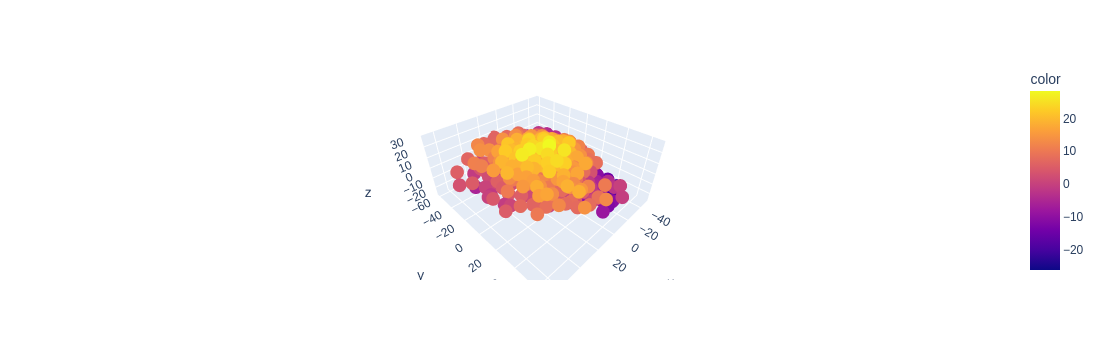

In [37]:
import plotly.express as px

fin_points_b = np.matmul(fin_df[["XP", "YP", "ZP"]].to_numpy() - shift_ref_vec1, base_axes.T)

fig = px.scatter_3d(x=fin_points_b[:, 0], y=fin_points_b[:, 1], z=fin_points_b[:, 2], color=fin_points_b[:, 2])
fig.show()